# PyTorch Layer 이해하기

# 예제 불러오기

In [27]:
import torch
from torchvision import datasets, transforms

In [28]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [29]:
#실제 학습에서는 정규화도 해줘야 한다.
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=1)

In [30]:
image, label = next(iter(train_loader))

In [31]:
#배치 사이즈 채널, h, w 순서이다.
image.shape , label.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

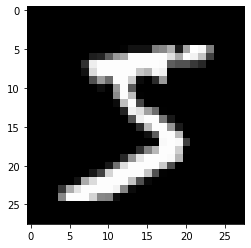

In [32]:
plt.imshow(image[0, 0 , : , :], 'gray')
plt.show()

# 각 Layer별 설명

- Network 쌓기 위한 준비

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Convolution

- in_channels: 받게 될 channel의 갯수
- out_channels: 보내고 싶은 channel의 갯수  
- kernel_size: 만들고 싶은 kernel(weights)의 사이즈

In [34]:
#앞에서 채널을 몇개를 받을지를 지정해줘야 한다. 그리고 out_channel도 두어야 한다.
#tensorflow는 filter를 만들었다.
nn.Conv2d(in_channels = 1, out_channels = 20, kernel_size = 5, stride= 1)

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [35]:
layer = nn.Conv2d(1,20,5,1).to(torch.device('cpu'))
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

- weight 시각화를 위해 slice하고 numpy화

In [36]:
#5 5 짜리 필터를 갖고, 1개의 채널이다.
weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

- 여기서 weight는 학습 가능한 상태이기 때문에 바로 numpy로 뽑아낼 수 없음
- detach() method는 그래프에서 잠깐 빼서 gradient에 영향을 받지 않게 함

In [37]:
#weight는 아직 train이 없는 상태라서 detach를 해주어야 numpy로 변형이 된다.
weight = weight.detach().numpy()
weight

array([[[[-0.11335275,  0.08404292, -0.02927966,  0.12421931,
          -0.17454135],
         [-0.1931496 , -0.15728958,  0.19683804, -0.05225651,
          -0.0431304 ],
         [-0.02051263, -0.08299255,  0.03595321, -0.02146848,
           0.00020957],
         [-0.04137829,  0.12199916, -0.10654092, -0.18860696,
          -0.05981779],
         [ 0.06945802,  0.05743934,  0.07681729, -0.11951929,
           0.19718303]]],


       [[[-0.04369792, -0.00795391, -0.04794335, -0.05987731,
           0.1704822 ],
         [ 0.0815414 ,  0.02570012,  0.11297013, -0.10927965,
          -0.03085682],
         [ 0.18567733,  0.1669363 , -0.061551  ,  0.04870017,
          -0.1479027 ],
         [ 0.00367245, -0.05786204, -0.19612575,  0.05034165,
          -0.07765871],
         [ 0.12807561, -0.03054805, -0.03297488,  0.09525122,
          -0.05394492]]],


       [[[ 0.06390779, -0.1926163 ,  0.04115185, -0.08734498,
          -0.0085599 ],
         [ 0.1337976 ,  0.14765202, -0.0450456

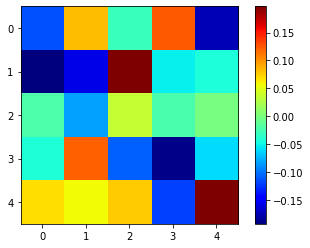

In [39]:
plt.imshow(weight[0,0,:,:],'jet')
plt.colorbar()
plt.show()

- output 시각화 준비를 위해 numpy화

In [40]:
output_data = layer(image)

In [42]:
output_data = output_data.data

In [43]:
output = output_data.cpu().numpy()

In [44]:
output.shape

(1, 20, 24, 24)

- Input으로 들어간 이미지 numpy화 

In [46]:
image_arr = image.numpy()
image_arr.shape

(1, 1, 28, 28)

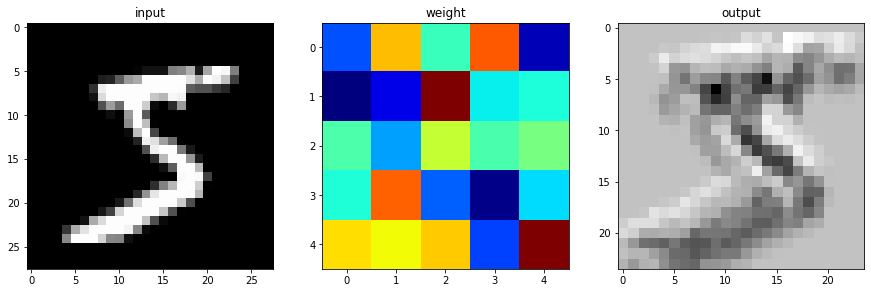

In [48]:
plt.figure(figsize=(15,30))
plt.subplot(131)
plt.title('input')
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(132)
plt.title('weight')
plt.imshow(weight[0,0,:,:], 'jet')
plt.subplot(133)
plt.title('output')
plt.imshow(output[0,0,:,:],'gray')
plt.show()

### Pooling

input을 먼저 앞에 넣고, 뒤에 kernel 사이즈와 stride를 순서대로 넣음

In [49]:
#conv는 했으니 pooling을 해주자
image.shape

torch.Size([1, 1, 28, 28])

In [50]:
#nn은 weight가 있는 것들
#nn.functional은 maxpooling, activation function과 같이 nn에 사용되지만 weight는 없는 것들
#2x2필터
pool = F.max_pool2d(image, 2, 2)
pool.shape

torch.Size([1, 1, 14, 14])

- MaxPool Layer는 weight가 없기 때문에 바로 numpy()가 가능

In [53]:
#weight가 없는 것들은 바로 numpy가능
pool_arr = pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

In [54]:
image_arr.shape

(1, 1, 28, 28)

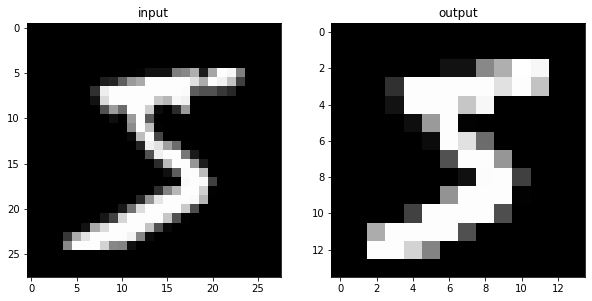

In [56]:
plt.figure(figsize=(10,15))
plt.subplot(121)
plt.title("input")
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(122)
plt.title('output')
plt.imshow(np.squeeze(pool_arr), 'gray')
plt.show()

### Linear

nn.Linear는 2d가 아닌 1d만 들어가기 때문에 .view() 1D로 펼쳐줘야함

In [57]:
#펼친다음에 linear를 거치는 과정
#따로 flatten 메서드가 없다 그래서,view나 reshape를 하자
#neural network 부분이다.
image.shape

torch.Size([1, 1, 28, 28])

In [59]:
#view로 선형화하되, 배치인 1은 없애면 안된다.
flatten = image.view(1,28*28)
flatten.shape

torch.Size([1, 784])

In [62]:
#784개를 받아서 10개로 내보는 것이다.
lin = nn.Linear(784,10)(flatten)
lin.shape

torch.Size([1, 10])

In [63]:
lin

tensor([[ 0.0800,  0.1233,  0.1547, -0.0483, -0.1848,  0.2460,  0.0434, -0.1351,
          0.1593,  0.0904]], grad_fn=<AddmmBackward>)

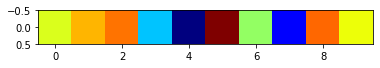

In [64]:
plt.imshow(lin.detach().numpy(), 'jet')
plt.show()

### Softmax

결과를 numpy로 꺼내기 위해선 weight가 담긴 Linear에 weight를 꺼줘야함

In [65]:
#detach를 해서 볼 수 있지만, with torch_no_grad으로도 볼 수 있다.
with torch.no_grad():
    flatten = image.view(1, 28 * 28)
    lin = nn.Linear(784 , 10)(flatten)
    softmax = F.softmax(lin, dim = 1)

In [66]:
softmax

tensor([[0.1019, 0.0985, 0.0929, 0.0882, 0.1045, 0.0987, 0.1149, 0.0909, 0.0971,
         0.1124]])

In [68]:
#1에 가까운 수가 나와야 한다.
np.sum(softmax.numpy())

1.0

# Layer 쌓기

예제 출처: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#id23

nn 과 nn.functional의 차이점
- nn은 학습 파라미터가 담긴 것 
- nn.functional은 학습 파라미터가 없는 것이라 생각하면 간단

- Image를 Model에 넣어서 결과 확인